# Makemore Part 4

> Becoming a backprop ninja

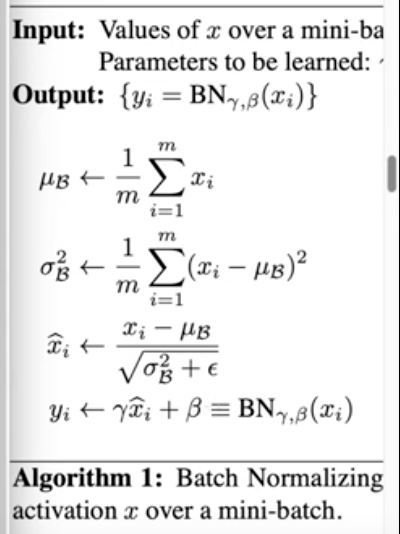

Before we go on to RNN, which are universal approximators, we would like to have a good intuitive understanding of the activations of a neural net during training and especially the gradients that are flowing backwards, how they behave and what they look like. This is required to understand why RNNs are not easily optimizable with the first order gradient based techniques that we use all the time.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
words = open('../names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #add special dot character to the vocabulary
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


The line of code AK takes issue with is the loss.backward(). While in Micrograd we did the backward pass at the level of scalars next we will work to write our backward pass manually on the level of tensors. 

Stop: 1m07s/1h55m23s

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3220, grad_fn=<NegBackward0>)

In [ ]:
# Stop: 12m55s/1h55m23s


* The idea here is to ALWAYS come up with a small example of 2 by 2 matrices that you can hand compute the derivatives. This allows us to see the pattern and then put that into the code.

* Bessel's correction is important when we have small batch sizes. There is a bug in Pytorch when we are using BatchNorm1D for small batch sizes because there isn't a way to tell PyTorch to use the correction.

* Observe the duality when a broadcast happens in the forward pass and then what happens in the backward pass (it turns into a sum) and vice versa.

In [ ]:
#KS1 - there is broadcasting happening here 
# c = a * b but with tensors
#a[3x3] * b[3x1] ---->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]

In [ ]:
# a11 a12 a13 --> b1 (=a11+a12+a13)
# a21 a22 a23 --> b2 (=a21+a22+a23)
# a31 a32 a33 --> b3 (=a31+a32+a33)

In [ ]:
# dembcat.shape

In [ ]:
# emb = C[Xb]
# print(emb.shape, C.shape, Xb.shape)
# print(Xb[:5])

In [ ]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

#------------------
# YOUR CODE HERE :)
#------------------
dlogprobs = torch.zeros_like(logprobs) #dlogprobs is shorthand for dL/dlogprobs (here L=loss)
dlogprobs[range(n), Yb] = -1./n
dprobs = (1./probs)*dlogprobs #dL/dprobs = (dlogprobs/dprobs) * dL/dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(dim=1,keepdim=True) #KS1 dL/dcounts_sum_inv = (dprobs/dcounts_sum_inv)*dL/dprobs

# KS2: can't compare to dcounts yet since there is another branch
dcounts = (counts_sum_inv * dprobs) #KS2 dL/counts = (dprobs/dcounts)*dL/dprobs

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv #dL/counts_sum = (dcounts_sum_inv/dcounts_sum)*dL/dcounts_sum_inv
dcounts += torch.ones_like(counts)*dcounts_sum #dL/counts += (dcounts_sum/dcounts)*dL/dcounts_sum
dnorm_logits = counts * dcounts #dL/dnorm_logits = (dcounts/dnorm_logits)*dL/dcounts

# norm_logits = logits - logit_maxes # subtract max for numerical stability
# KS 3: broadcasting happens during the subtraction
dlogit_maxes = (-torch.ones_like(logit_maxes) * dnorm_logits).sum(dim=1,keepdim=True) #KS3 dL/dlogit_maxes = (dnorm_logits/dlogit_maxes) *(dL/dnorm_logits)
# dlogits = torch.ones_like(logits) * dnorm_logits #dL/dlogits = (dnorm_logits/dlogits) *(dL/dnorm_logits)
dlogits = dnorm_logits.clone()

# logit_maxes = logits.max(1, keepdim=True).values
# only allow the gradient to flow towards that logit column which was the maximum on any given example
# tmp = torch.zeros_like(logits)
# tmp[range(n),logits.argmax(dim=1)] = 1
# dlogits += tmp * dlogit_maxes   #dL/dlogits += dlogit_maxes/dlogits * dL/dlogit_maxes
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes =  logits.shape[1]) * dlogit_maxes

# logits = h @ W2 + b2 # output layer
# Note the pattern of there being one term for every item
# in the expression above. And we have the use of the dlogits (global backward gradient) 
# multiplying on the right hand sides
dh =  dlogits @ W2.T # dL/dh = dlogits/dh * dL/dlogits
dW2 = h.T @ dlogits
db2  = dlogits.sum(dim=0)

# h = torch.tanh(hpreact)
dhpreact = (1.0 - h**2)* dh# dL/dhpreact = dh/dhpreact * dL/dh

# hpreact = bngain * bnraw + bnbias (ELEMENT WISE multiply with broadcasting here!!)
dbngain = (bnraw * dhpreact).sum(dim=0,keepdim=True) # dhpreact/bngain * dL/dhpreact
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(dim=0,keepdim=True)

#bnraw = bndiff * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(dim=0,keepdim=True)
dbndiff = bnvar_inv * dbnraw

#bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5*((bnvar + 1e-5)**(-1.5)) * dbnvar_inv).sum(dim=0,keepdim=True)

#bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
dbndiff2 = ( (1/(n-1)) * torch.ones_like(bndiff2) ) *  dbnvar

#bndiff2 = bndiff**2
dbndiff += (2 * bndiff) * dbndiff2

# bndiff = hprebn - bnmeani
dbnmeani = (-1.*torch.ones_like(bnmeani) * dbndiff).sum(dim=0,keepdim=True)
dhprebn = dbndiff.clone()

#bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn += ( (1/n) * torch.ones_like(hprebn) ) * dbnmeani

#hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1  = dhprebn.sum(dim=0)

#embcat = emb.view(emb.shape[0], -1)
demb = dembcat.view(emb.shape)

# emb = C[Xb]
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]): #iterate over each example
    for j in range(Xb.shape[1]): #over each character in the context
        ix = Xb[k,j] # look up the character's index
        dC[ix] += demb[k,j] # deposit the gradient (multiple times if necessary) #1h25m50s

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv) #26m20s
cmp('counts_sum', dcounts_sum, counts_sum) #28m54s
cmp('counts', dcounts, counts) #32m28s
cmp('norm_logits', dnorm_logits, norm_logits) #33m10s
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)#41m47s
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [ ]:
# 04/07/2023 - Stop: 20m55s/1h55m23s
# 04/08/2023 - Stop: 33m10s/1h55m23s
# 04/09/2023 - Stop: 55m14s/1h55m23s
# 04/10/2023 - Stop: 59m41s/1h55m23s
# 04/11/2023 - Stop: 1h26m27s/1h55m23s (backpropogated through the entire beast!!!)

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.321981191635132 diff: 0.0


In [ ]:
logits.shape, Yb.shape, (F.one_hot(Yb, num_classes =  logits.shape[1])).shape

(torch.Size([32, 27]), torch.Size([32]), torch.Size([32, 27]))

In [ ]:
# backward pass
#------------------
# YOUR CODE HERE :)
#------------------
# https://nasheqlbrm.github.io/blog/posts/2021-08-07-cross-entropy-loss-pytorch.html
# dlogits = (1./n) * ( probs - F.one_hot(Yb, num_classes =  probs.shape[1]) )
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [ ]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [ ]:
F.softmax(logits, 1)[0]

tensor([0.0749, 0.0805, 0.0187, 0.0475, 0.0196, 0.0838, 0.0230, 0.0348, 0.0196,
        0.0319, 0.0371, 0.0337, 0.0389, 0.0294, 0.0371, 0.0146, 0.0090, 0.0191,
        0.0154, 0.0557, 0.0511, 0.0219, 0.0284, 0.0655, 0.0588, 0.0284, 0.0214],
       grad_fn=<SelectBackward0>)

In [ ]:
# same as the previous cell except for the location of the label for the example (index (zero based) 
# 8 in this case)
dlogits[0] * n

tensor([ 0.0749,  0.0805,  0.0187,  0.0475,  0.0196,  0.0838,  0.0230,  0.0348,
        -0.9804,  0.0319,  0.0371,  0.0337,  0.0389,  0.0294,  0.0371,  0.0146,
         0.0090,  0.0191,  0.0154,  0.0557,  0.0511,  0.0219,  0.0284,  0.0655,
         0.0588,  0.0284,  0.0214], grad_fn=<MulBackward0>)

In [ ]:
# dlogits is the amount of push and pull exerted on the probabilities
# we pull up the probability of the correct example and push down on
# the others in a way such that the sum of the pushes and pull sums to zero
dlogits[0].sum()

tensor(1.3970e-09, grad_fn=<SumBackward0>)

<matplotlib.image.AxesImage>

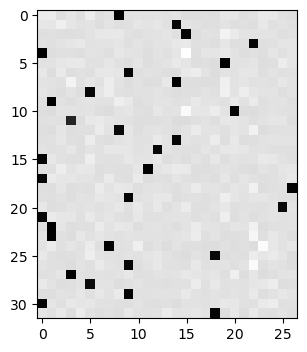

In [ ]:
# Here the dark corresponds to a pull
# the lights correspond to the pushes.
# Thus, training a neural network can be thought of as some physical pulley
# system where these pushes and pull are gradually shaping the weights and biases
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# 04/12/2023 - Stop: 1h36m39s/1h55m23s